In [ ]:
from traceback import print_tb

#Importing necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from setuptools.command.install import install
from shapely.geometry import Point, Polygon
import re
from rapidfuzz import fuzz
from scipy.spatial import KDTree



In [4]:
#Uploading data using False low_memory to detect and handle different types of inputs in the columns
#A copy of the raw data file is used to prevent damage of original information
#modify with your own path
path_roads= "C:/Users/ralph/Documents/git/Advanced-Simulation---Group-12/data/raw/_roads_1.tsv"
path_bridges= "C:/Users/ralph/Documents/git/Advanced-Simulation---Group-12/data/raw//BMMS_overview_1.xlsx"
path_roads_info = "C://Users//ralph//Documents//git//Advanced-Simulation---Group-12//data//raw//Roads_InfoAboutEachLRP_1.csv"
roads= pd.read_csv(path_roads, sep='\t', low_memory=False)
bridges=pd.read_excel(path_bridges)
roads_info=pd.read_csv(path_roads_info)

# Roads file: Resolving Distances between LRP points

This part of the code will focus on the _"_roads.tsv"_ file and implement a solution to eliminate noise from the data and ultimately improve the simulation output. 

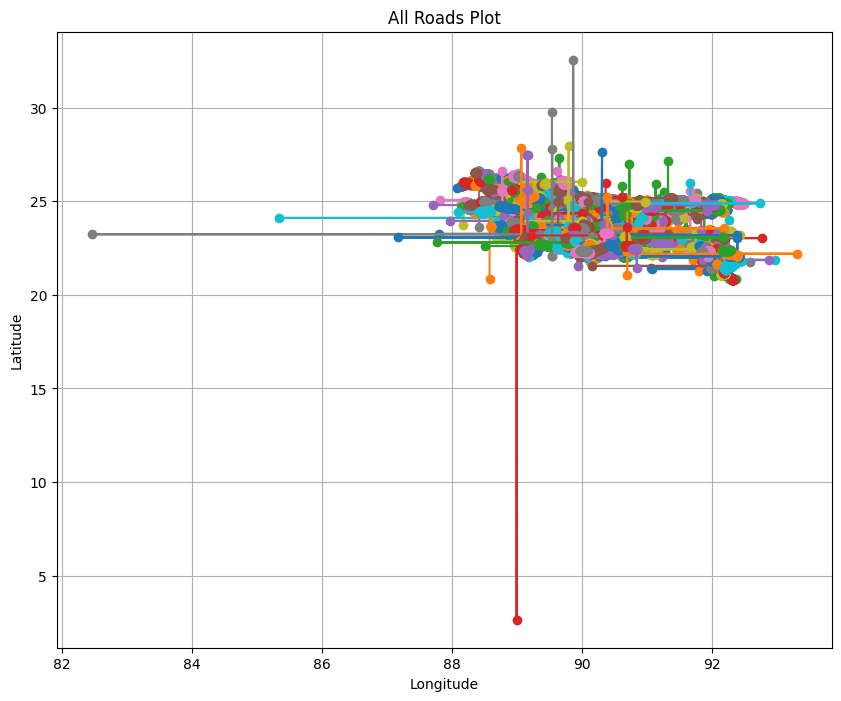

In [5]:
# Vizualizing the data
# Create a plot
plt.figure(figsize=(10, 8))

# Loop through each row in the dataframe (each road)
for index, row in roads.iterrows():
    # Extract the name of the road (first column)
    road_name = row.iloc[0]
    
    # Extract latitude and longitude values from the row
    latitudes = []
    longitudes = []
    
    # Extract latitude and longitude for each LRP, assuming columns are in a pattern
    for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
        latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
        longitudes.append(row.iloc[i+2])  # Column i+2 is longitude
    
    # Plot the road (connecting the points)
    plt.plot(longitudes, latitudes, marker='o', label=f'{road_name}')

# Customize the plot
plt.title('All Roads Plot')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)


# Show the plot
plt.show()

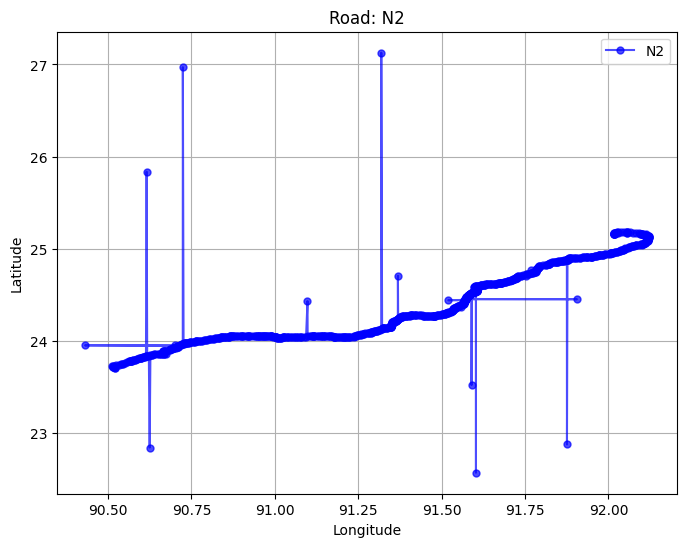

In [6]:
# Zooming into one road to take a closer look at the outliers shown in the "All roads plot" 
# Select a row of importance form the dataset
row = roads.iloc[22]

# Extract the name of the road (first column)
road_name = row.iloc[0]

# Extract latitude and longitude values from the row
latitudes = []
longitudes = []

# Extract latitude and longitude for each LRP
for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
    latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
    longitudes.append(row.iloc[i+2])  # Column i+2 is longitude

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the road (first row)
plt.plot(longitudes, latitudes, marker='o', markersize=5, linestyle='-', color='blue', alpha=0.7, label=f'{road_name}')

# Customize the plot
plt.title(f'Road: {road_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Creating a distance function
To clean up the roads.tsv file and ensure continuity of the roads, we have to eliminate outliers amongst the LRPs for each road. To do this, we create a function that calculates the distances between the LRPs of one specific highway. We hope to eventually eliminate those LRPs that deviate too much from the average distance.

In [7]:
# Defining the function
def find_distance(row):
    latitudes = []
    longitudes = []
    distances = np.array([])
    
    # The iteration jumps in 3 columns every run, starting column 1)
    for i in range(1, len(row),3):
        latitudes.append(row.iloc[i+1])
        longitudes.append(row.iloc[i+2])
        
    # Creating an iteration to calculate the distance between two LRP using Pythagoras theorem
    # The iterator starts at 1 to be able to access the previous point using j-1
    for j in range (1, len(latitudes)):
        #converting to float to tackle longitudes and latitudes being stored as np.float64
        distance= float(np.sqrt((latitudes[j]-latitudes[j-1])**2 + (longitudes[j]-longitudes[j-1])**2)) #using pythagoras theorem to calculate distance
        distances= np.append(distances, distance)
    return distances

    

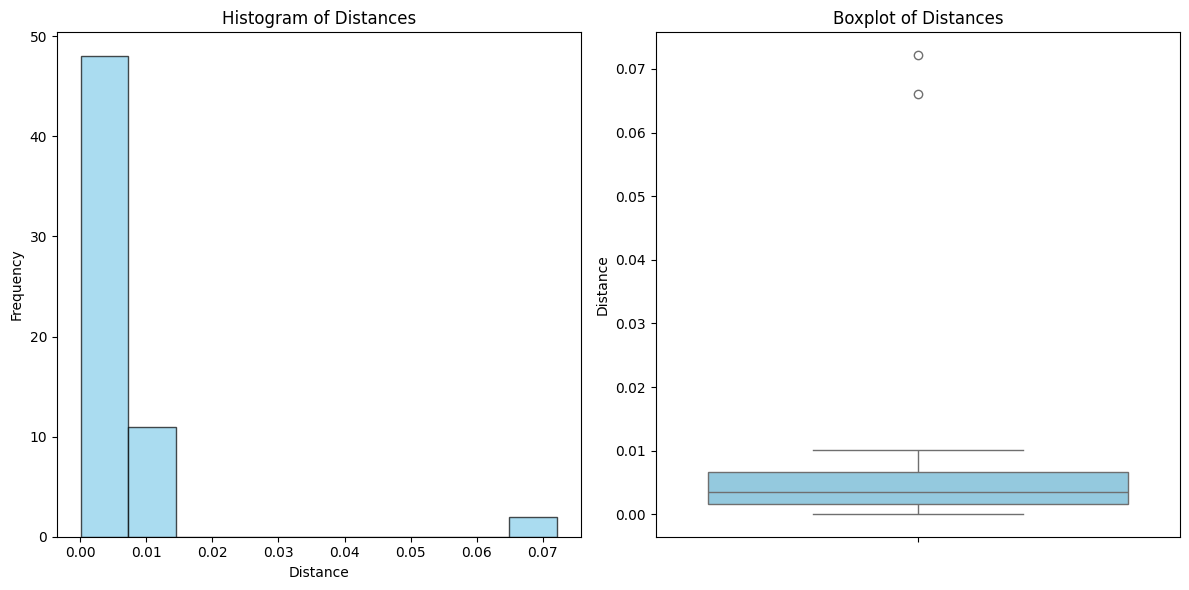

In [8]:
# Testing the function on N1 road (and others) and seeing if distribution is somewhat normal, but it is not. 
# Feel free to change the index in line 4 to test other roads
import seaborn as sns
distances_row = find_distance(roads.iloc[659])
# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plotting histogram to see the distribution
plt.subplot(1, 2, 1)  # (rows, columns, position)
plt.hist(distances_row, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Distances")
plt.xlabel("Distance")
plt.ylabel("Frequency")

# Plotting box plot to identify outliers
plt.subplot(1, 2, 2)
sns.boxplot(data=distances_row, color='skyblue')
plt.title("Boxplot of Distances")
plt.ylabel("Distance")

# Show the plots
plt.tight_layout()
plt.show()


# Identifying Outliers

To identify outliers, we use percentiles to detect LRPs (Location Reference Points) whose distances deviate significantly from the majority. This method is preferred over standard deviation since road distances do not follow a normal distribution.

## Indexing Structure

- The **latitude** and **longitude** arrays are structured as:
  - `latitudes = [a, b, c, d, ...]`
  - `longitudes = [e, f, g, h, ...]`
  - The index in these arrays corresponds to **LRP positions**.

- The **distances** array represents the calculated distances between consecutive LRPs:
$$
d(i) = \sqrt{(latitudes[i+1] - latitudes[i])^2 + (longitudes[i+1] - longitudes[i])^2}
$$
  This means:

  \[
  distances = \left[\sqrt{(b-a)^2 + (f-e)^2}, \sqrt{(c-b)^2 + (g-f)^2}, \sqrt{(d-c)^2 + (h-g)^2}, ...\right]
  \]

  - Each element represents the distance between two consecutive points in the latitude and longitude arrays.

## How Indexing Works

1. The **distances array** index corresponds to `i` in the latitudes and longitudes arrays, meaning:
   - `distances[i]` = distance between `latitudes[i]` and `latitudes[i+1]`
   - `distances[i]` = distance between `longitudes[i]` and `longitudes[i+1]`

2. If an **LRP is an outlier**, two consecutive distances will be outliers, meaning:
   - The **outliers_index array** stores the positions of these outliers in the `distances` array.

3. Since each LRP is defined in the **roads DataFrame**, the corresponding row index follows:
   - `roads.iloc[outlier_index * 3 + 1]` → **Latitude**
   - `roads.iloc[outlier_index * 3 + 2]` → **Longitude**
   - Multiplication by 3 accounts for the 3-column structure per LRP.

## Example

Consider the first four LRPs of a road segment:

| LRP | Latitude  | Longitude  | Distance to Next |
|-----|----------|-----------|-----------------|
| 0   | a        | e         | d(b-a, f-e)     |
| 1   | b        | f         | d(c-b, g-f)     |
| 2   | c        | g         | d(d-c, h-g)     |
| 3   | d        | h         | -               |

- If **LRP 2** `(c, g)` is an outlier:
  - Distances at positions `1` and `2` in the `distances` array will be outliers.
  - `outliers_index = [1, 2]`
  - Checking the indexes, we find the relevant LRP is at position `1+1 = 2`.
  - This LRP corresponds to index `1` in the **roads** DataFrame.

By following this logic, we accurately map outlier indexes to their corresponding LRPs in the dataset.

In [9]:
def find_outlier(row_location, distances, percentile):   #percentile is added is a function variable since different tresholds are needed for different roads
    #add longitude and latitude arrays as input
    # Finding the outliers
    outliers_index = []
    outliers_latitude = []
    outliers_longitude = [] 
    #use np.nanpercentile to ignore NaN values and not mess the treshold if the road is shorter than the rest
    limit = np.nanpercentile(distances,percentile)  # Adjust the percentile value as needed
    print(limit)
    
    for i in range(0, len(distances)):
        if distances[i] > limit:
            outliers_index.append(i)

    #Store longitutes and latitudes that need to be eliminated form dataset to clear discontinuities
    for outlier_LRP in outliers_index:
        #modify to look into the longitutde and latitude arrays
        outliers_latitude.append(float(roads.iloc[row_location, 1+ outlier_LRP*3 +1])) # Multiply by 3 to take into account the 3 columns per LRP, add 1 in the beggining to skip the road name
        outliers_longitude.append(float(roads.iloc[row_location, 1+ outlier_LRP*3+ 2])) 
        
    return outliers_index, outliers_latitude, outliers_longitude
 

# Smoothening the data
### Interpolation

To correct the data where outliers are found, we use interpolation to fill in the missing values. This is done by taking the average of the two closest points to the outlier. We use this method od estimation to tackle the accuracy issue of the roads dataset and to ensure continuity and linearity of the roads.

In [10]:
def interpolate_outliers(outliers_index, road_location):
    # Interpolating the outliers
    road_newroads = roads.copy()
    for call in outliers_index:
        # Calculate the average of the two closest points
        #Started indexing at 1 to make sure there are at least two data-point before the first LRP checked
        if call>1 and call<len(road_newroads.columns)/3-2:
            #finding the average between the points located two steps before and two steps after the outlier to ensure it's on the meaningful road. 
            avg_lat = (float(roads.iloc[road_location, 1+ (call-2) *3 +1]) + float(roads.iloc[road_location, 1+ (call+2)*3 +1])) / 2
            avg_long = (float(roads.iloc[road_location, 1+ (call-2) *3 +2]) + float(roads.iloc[road_location, 1+ (call+2)*3 +2])) / 2
        
            # Replace the outliers with the average value
            road_newroads.iloc[road_location, 1+ call*3 +1] = avg_lat
            road_newroads.iloc[road_location, 1+ call*3 +2] = avg_long
        
    return road_newroads

# Applying the functions to the dataset

We apply the designed functions to roads N1 and N2 of the dataset, which are critical to the socio-economical stability of Bangladesh, being some of the main national roads of the country. 


In [12]:
N1= roads.iloc[0]
N1_distances= find_distance(N1)
N1_outliers_index, N1_outliers_latitude, N1_outliers_longitude = find_outlier(0, N1_distances, 70)
N1_processed= interpolate_outliers(N1_outliers_index, 0)
#saving the processed data to a new file on a relative path
file_path_N1 = 'C://Users//ralph//Documents//git//Advanced-Simulation---Group-12//data//processed/N1_processed.csv'
N1_processed.to_csv(file_path_N1)

0.004096661312599427


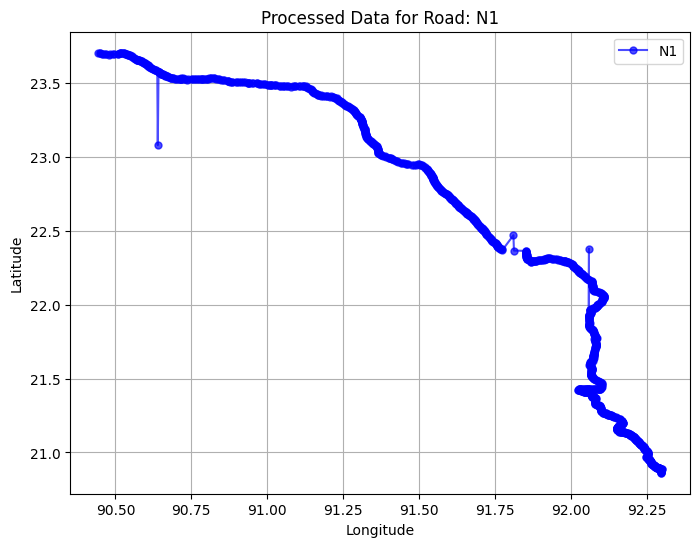

In [13]:
#modeling the N1 road visually to see the difference between the original and processed data
# Create a plot

row = N1_processed.iloc[0]

# Extract the name of the road (first column)
road_name = row.iloc[0]

# Extract latitude and longitude values from the row
latitudes = []
longitudes = []

# Extract latitude and longitude for each LRP
for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
    latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
    longitudes.append(row.iloc[i+2])  # Column i+2 is longitude

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the road (first row)
plt.plot(longitudes, latitudes, marker='o', markersize=5, linestyle='-', color='blue', alpha=0.7, label=f'{road_name}')

# Customize the plot
plt.title(f'Processed Data for Road: {road_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [14]:
#Find out position of N2 in roads datset
# Find the index where 'N2' appears in the first column
#adjust to find any road in the dataset by changin the string
n2_index = roads[roads.iloc[:, 0] == 'N2'].index[0]

# Show the index (or indices) where 'N2' is found
print(n2_index)

22


In [16]:
#Applying the functions to the N2 road
N2= roads.iloc[n2_index]
N2_distances= find_distance(N2)
N2_outliers_index, N2_outliers_latitude, N2_outliers_longitude = find_outlier(22,N2_distances,50)
N2_processed= interpolate_outliers(N2_outliers_index, n2_index)
file_path_N2= 'C://Users//ralph//Documents//git//Advanced-Simulation---Group-12//data//processed/N2_processed.csv'
N2_processed.to_csv(file_path_N2)

0.0025183444881534053


N2


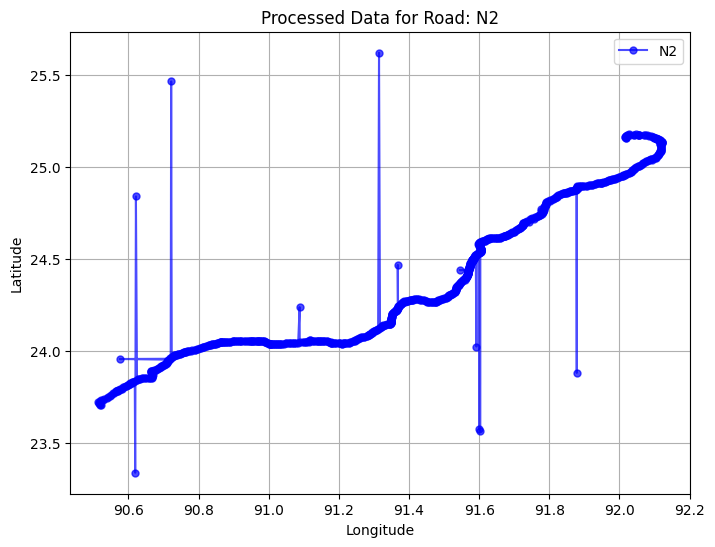

In [17]:
#modeling the N2 road visually to see the difference between the original and processed data    
row = N2_processed.iloc[n2_index]
# Extract the name of the road (first column)
road_name = row.iloc[0]
print(road_name)
# Extract latitude and longitude values from the row
latitudes = []
longitudes = []

# Extract latitude and longitude for each LRP
for i in range(1, len(row), 3):  # every 3rd column is latitude and longitude
    latitudes.append(row.iloc[i+1])   # Column i+1 is latitude
    longitudes.append(row.iloc[i+2])  # Column i+2 is longitude

# Create the plot
plt.figure(figsize=(8, 6))

# Plot the road (first row)
plt.plot(longitudes, latitudes, marker='o', markersize=5, linestyle='-', color='blue', alpha=0.7, label=f'{road_name}')

# Customize the plot
plt.title(f'Processed Data for Road: {road_name}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

## Bridges: Filtering of Bridges

In this section the dataset bridges.tsv will be used, in addition to Roads_InfoAboutEachLRP_1.csv to filter the bridges that are not in Bangladesh, not connected to land, are duplicate, are not connected to a road.
Moreover formatting issues in the longitude and latitude and in the naming will be resolved.

First, an approximate bounding box for Bangladesh using minimum and maximum latitude and longitude values is established. Additionally, a polygon representing the country's approximate land area for more precise geographic filtering is made. Then, the bridges dataset is filtered to retain only those with coordinates that fall within the defined bounding box, ensuring that only bridges located inside Bangladesh are kept.

In [18]:

# Define Bangladesh's bounding box (approximate)
bangladesh_bounds = {
    "lat_min": 20.5,
    "lat_max": 26.6,
    "lon_min": 88.0,
    "lon_max": 92.7
}

# Define Bangladesh's approximate land polygon (for better filtering)
land_polygon = Polygon([
    (88.0, 20.5), (92.7, 20.5), (92.7, 26.6), (88.0, 26.6), (88.0, 20.5)
])

# Filter bridges within Bangladesh's bounding box
bmms_overview_filtered = bridges[
    (bridges["lat"] >= bangladesh_bounds["lat_min"]) &
    (bridges["lat"] <= bangladesh_bounds["lat_max"]) &
    (bridges["lon"] >= bangladesh_bounds["lon_min"]) &
    (bridges["lon"] <= bangladesh_bounds["lon_max"])
]


### Standardizing Bridge Names

This function cleans bridge names by converting them to uppercase, removing extra spaces, special characters, and the redundant term "BRIDGE." The cleaned names are then stored in a new column, `cleaned_name`, ensuring consistency in data processing.


In [19]:

# Standardize bridge names
def clean_name(name):
    if pd.isna(name) or not isinstance(name, str):  # Handle NaN or non-string values
        return ""
    name = name.upper().strip()  # Convert to uppercase and remove extra spaces
    name = re.sub(r'\s+', ' ', name)  # Normalize spaces
    name = re.sub(r'[^A-Z0-9 ]', '', name)  # Remove special characters
    name = re.sub(r'\bBRIDGE\b', '', name)  # Remove redundant terms
    return name.strip()


bmms_overview_filtered['cleaned_name']=bmms_overview_filtered['name'].apply(clean_name)

C:\Users\ralph\AppData\Local\Temp\ipykernel_23176\952592689.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bmms_overview_filtered['cleaned_name']=bmms_overview_filtered['name'].apply(clean_name)


### Extracting and Cleaning Bridge Names (left right errors)

This code extracts Left/Right indicators (`L`, `R`, `1`, `2`) from bridge names and standardizes them into a new column, `LR_indicator`. It also cleans the `name` column by removing these indicators, unnecessary dots, and text inside parentheses to ensure consistency in bridge naming.


In [20]:
# Extract Left/Right indicators
def extract_lr(name):
    """
    Extracts Left/Right indicators (L, R, 1, 2) from the bridge name
    and standardizes them as 'L' or 'R'.
    """
    if pd.isna(name) or not isinstance(name, str):  # Handle NaN or non-string values
        return None
    
    name = name.upper().strip()  # Standardize case

    # Check for left/right indicators
    if re.search(r'\b(LEFT|L|1)\b', name):
        return 'L'
    elif re.search(r'\b(RIGHT|R|2)\b', name):
        return 'R'
    else:
        return None  # No left/right indicator found

# Create a new column for Left/Right information
bmms_overview_filtered['LR_indicator'] = bmms_overview_filtered['name'].apply(extract_lr)

# Remove L/R indicators and parentheses from the bridge name
def clean_name(name):
    if pd.isna(name) or not isinstance(name, str):
        return ""
    name = name.upper().strip()
    
    # Remove L/R indicators
    name = re.sub(r'\b(LEFT|RIGHT|L|R|1|2)\b', '', name)

    # Remove dots 
    name = re.sub(r'\.', '', name)
    
    # Remove text inside parentheses (and the parentheses themselves)
    name = re.sub(r'\(.*?\)', '', name)  # Removes anything inside ( ... )
    
    # Remove extra spaces
    name = re.sub(r'\s+', ' ', name).strip()

    return name

bmms_overview_filtered['cleaned_name']=bmms_overview_filtered['name'].apply(clean_name)


C:\Users\ralph\AppData\Local\Temp\ipykernel_23176\2974414375.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bmms_overview_filtered['LR_indicator'] = bmms_overview_filtered['name'].apply(extract_lr)
C:\Users\ralph\AppData\Local\Temp\ipykernel_23176\2974414375.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bmms_overview_filtered['cleaned_name']=bmms_overview_filtered['name'].apply(clean_name)


### Identifying and Merging Duplicate Bridges

This code detects potential duplicate bridges using **fuzzy name matching** and **location-based comparison**. It groups bridges by road and checks for similarities in cleaned names, latitude, longitude, and chainage, flagging close matches as duplicates. The `merge_duplicates` function then combines duplicate entries by filling missing values and removing redundant rows. This process helps ensure data consistency while preserving as much information as possible.


In [21]:
# Identify potential duplicates using fuzzy matching and location data
def find_duplicates(group, threshold=90):
    duplicates = []
    for i, row1 in group.iterrows():
        for j, row2 in group.iterrows():
            if i >= j:
                continue
            name_similarity = fuzz.ratio(row1["cleaned_name"], row2["cleaned_name"])
            lat_diff = abs(row1["lat"] - row2["lat"])
            lon_diff = abs(row1["lon"] - row2["lon"])
            chainage_diff = abs(row1["chainage"] - row2["chainage"])
            if name_similarity > threshold and lat_diff < 0.001 and lon_diff < 0.001 and chainage_diff < 0.1:
                duplicates.append((i, j))
    return duplicates

# Group by road and find duplicates within each group
duplicates = []
grouped = bmms_overview_filtered.groupby("road")
for _, group in grouped:
    duplicates.extend(find_duplicates(group))

In [22]:
# Merge duplicate rows
def merge_duplicates(df, duplicates):
    merged_indices = set()
    max_index = len(df) - 1  # Maximum valid index in the DataFrame

    for i, j in duplicates:
        # Skip if indices are invalid
        if i > max_index or j > max_index:
            print(f"Skipping invalid indices: ({i}, {j})")
            continue
        # Skip if indices are already merged
        if i in merged_indices or j in merged_indices:
            continue
        # Merge rows
        row1 = df.iloc[i]
        row2 = df.iloc[j]
        merged_row = row1.combine_first(row2)  # Fill missing data in row1 with row2
        df.iloc[i] = merged_row
        merged_indices.add(j)

    # Drop the merged rows
    df = df.drop(index=list(merged_indices)).reset_index(drop=True)
    return df

bmms_overview_filtered_cleaned = merge_duplicates(bmms_overview_filtered, duplicates)


Skipping invalid indices: (19824, 21260)
Skipping invalid indices: (19827, 21265)
Skipping invalid indices: (14114, 21280)
Skipping invalid indices: (21301, 21302)
Skipping invalid indices: (14490, 21308)
Skipping invalid indices: (19956, 21308)
Skipping invalid indices: (19957, 21308)
Skipping invalid indices: (20027, 21338)
Skipping invalid indices: (20213, 21390)
Skipping invalid indices: (20215, 21391)


### Merging Spatially Duplicate Bridges

This function identifies and merges spatially close duplicate bridges using a **KDTree** for efficient spatial queries. It detects bridge pairs within a small distance threshold (`0.001` degrees) and merges them by filling missing data from one row to another. The function ensures that redundant entries are removed while preserving relevant information. This approach helps eliminate duplicate bridge records caused by slight variations in recorded coordinates.


In [23]:
# Merge spatial duplicates
def merge_spatial_duplicates(df, distance_threshold=0.001):
    # Create a KDTree for fast spatial queries
    coords = df[['lat', 'lon']].values
    tree = KDTree(coords)

    # Query the tree for pairs within the distance threshold
    pairs = tree.query_pairs(distance_threshold)

    # Merge spatially close rows
    merged_indices = set()
    for i, j in pairs:
        if i in merged_indices or j in merged_indices:
            continue  # Skip if already merged
        # Merge rows
        row1 = df.iloc[i]
        row2 = df.iloc[j]
        merged_row = row1.combine_first(row2)  # Fill missing data in row1 with row2
        df.iloc[i] = merged_row
        merged_indices.add(j)

    # Drop the merged rows
    df = df.drop(index=list(merged_indices)).reset_index(drop=True)
    return df

# Merge spatial duplicates
bmms_overview_filtered_cleaned = merge_spatial_duplicates(bmms_overview_filtered_cleaned, distance_threshold=0.001)


Some bridges have a swapped longitude and latitude. This is identified here and solved by switching them

In [24]:
# Fix bridges with swapped latitude and longitude (where lat > lon)
mask_swapped = bmms_overview_filtered_cleaned["lat"] > bmms_overview_filtered_cleaned["lon"]
bmms_overview_filtered_cleaned.loc[mask_swapped, ["lat", "lon"]] = bmms_overview_filtered_cleaned.loc[mask_swapped, ["lon", "lat"]].values

### Removing Bridges that are too small
Bridges with a length of less than 1 meter and width of more than a 100 meter are filtered out

In [25]:
# Define thresholds for valid bridges
MIN_LENGTH_THRESHOLD = 1    # Remove bridges shorter than 1m
MAX_WIDTH_THRESHOLD = 100   # Remove bridges wider than 100m

# Filter dataset
bmms_overview_filtered_cleaned = bmms_overview_filtered_cleaned[(bmms_overview_filtered_cleaned['length'] 
                                                                 >= MIN_LENGTH_THRESHOLD) & (bmms_overview_filtered_cleaned['width'] <= MAX_WIDTH_THRESHOLD)]

### Filtering Bridges Not Connected to Land or Roads

This code removes bridges that are not located on land by checking if their coordinates fall within a defined land polygon. It then identifies bridges connected to roads by merging the dataset with `Roads_InfoAboutEachLRP` based on latitude and longitude. Bridges that are either outside Bangladesh or not connected to roads are flagged as disconnected. Finally, only the valid bridges that are both on land and linked to roads are saved in `filtered_bridges


In [34]:
# Remove bridges not connected to land
bmms_overview_filtered_cleaned["is_on_land"] = bmms_overview_filtered_cleaned.apply(
    lambda row: land_polygon.contains(Point(row["lon"], row["lat"])), axis=1
)
bmms_overview_filtered_cleaned = bmms_overview_filtered_cleaned[bmms_overview_filtered_cleaned["is_on_land"]]

# Convert road and bridge coordinates to NumPy arrays for KDTree search
road_coords = roads_info[['lat', 'lon']].dropna().to_numpy()
bridge_coords = bmms_overview_filtered_cleaned[['lat', 'lon']].dropna().to_numpy()

# Create a KDTree for efficient nearest-neighbor search
tree = KDTree(road_coords)

# Find the nearest road for each bridge
distance_threshold = 0.001  # Approx. 100 meters
distances, indices = tree.query(bridge_coords)

# Identify bridges that have a road nearby
bmms_overview_filtered_cleaned["is_connected_to_road"] = distances < distance_threshold

# Keep only bridges that are on land AND near a road
connected_bridges = bmms_overview_filtered_cleaned[bmms_overview_filtered_cleaned["is_connected_to_road"]]

# Bridges that are either outside Bangladesh or not connected to roads
disconnected_bridges = bmms_overview_filtered_cleaned[~bmms_overview_filtered_cleaned["is_connected_to_road"]]

# Save the filtered bridges that are connected to roads and within Bangladesh
connected_bridges.to_csv("filtered_bridges.csv", index=False)

The results are plotted, comparing it to the original data

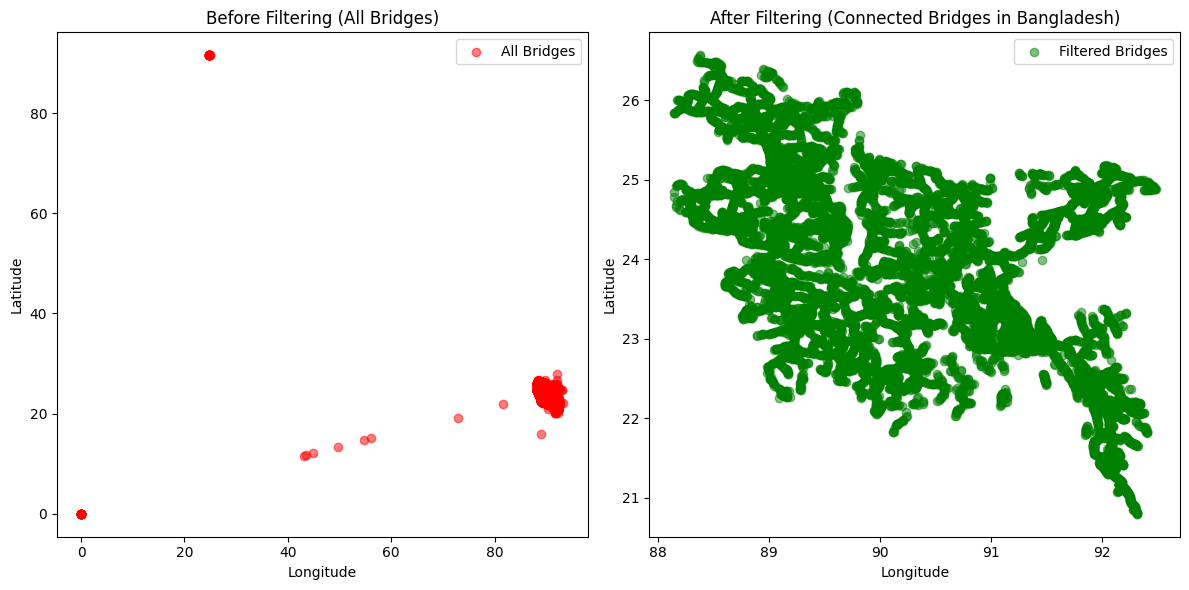

Filtered bridges saved to 'filtered_bridges.csv'
Original dataset had 21259 bridges.
Filtered dataset has 13905 bridges connected to roads within Bangladesh.


In [35]:
# Plot before and after filtering
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Before filtering (all bridges in dataset)
axes[0].scatter(bridges["lon"], bridges["lat"], color='red', alpha=0.5, label="All Bridges")
axes[0].set_title("Before Filtering (All Bridges)")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].legend()

# After filtering (only connected bridges within Bangladesh)
axes[1].scatter(connected_bridges["lon"], connected_bridges["lat"], color='green', alpha=0.5, label="Filtered Bridges")
axes[1].set_title("After Filtering (Connected Bridges in Bangladesh)")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].legend()

plt.tight_layout()
plt.show()

print("Filtered bridges saved to 'filtered_bridges.csv'")
print(f"Original dataset had {len(bmms_overview_filtered)} bridges.")
print(f"Filtered dataset has {len(connected_bridges)} bridges connected to roads within Bangladesh.")